<a href="https://colab.research.google.com/github/williamsun-hha/Google-Colab-LLM/blob/main/Copy_of_Setup_and_query_a_ollama_server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Google Colab as a model server

![](https://cdn-images-1.medium.com/max/880/1*4EmNlLcwG4Zg2tp3QAbymA.jpeg)

## Prerequisites
- Be able to run [Colab notebooks](https://colab.google/)
- Sign up to [ngrok](https://ngrok.com/) and copy your [authtoken](https://dashboard.ngrok.com/get-started/your-authtoken)

## Setting up the server

### At the Colab notebook instance
1. Start a Colab notebook instance.
  - This works with GPU or CPU, make sure to use a model optimized for the chosen hardware.
2. Setup your environment.
  - Download and install [Ollama](https://github.com/ollama/ollama?tab=readme-ov-file#linux)
  - Install ngrok.
  - Load the dependencies.
3. Set the ngrok authtoken and server port.
4. Start `Ollama` server.
5. Setup the `ngrok` credentials.
6. Open the `ngrok` tunnel.
7. Copy public URL, it will look something like this: `https://ae63-35-230-113-242.ngrok-free.app`.

After following the steps above you will be able to query the model hosted by Colab through your terminal, another notebook, or any other source.

## Prompting the model

### Local terminal
1. On your terminal, update your `OLLAMA_HOST` env variable with `export OLLAMA_HOST={OLLAMA_HOST_URL}` where `OLLAMA_HOST_URL` should be replaced by the address created at the previous step.
2. Load a model onto the server with `ollama run {MODEL_ID}` where `MODEL_ID` could be any [model supported by Ollama](https://ollama.com/search) like `gemma2:2b`.
3. After running `ollama run {MODEL_ID}` you will be able to query the model at the terminal.

### Jupyter notebook
The easiest way to query the ollama server would be with the [ollama-python](https://github.com/ollama/ollama-python), but you can also use something like the `requests` library as you would query any other API.

# GPU information

In [ ]:
!nvidia-smi

Sun Mar 16 19:21:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Setup

In [ ]:
# Download and install ollama to the system
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
!pip install -qq pyngrok ollama

# Dependencies

In [ ]:
import IPython
import subprocess
from pyngrok import ngrok
from google.colab import userdata
from typing import Any, Dict, List, Optional

# Auxiliary functions

In [ ]:
def start_ollama_server() -> None:
    """Starts the Ollama server."""
    subprocess.Popen(['ollama', 'serve'])
    print("Ollama server started.")


def check_ollama_port(port: str) -> None:
    """Check if Ollama server is running at the specified port."""
    try:
        subprocess.run(['sudo', 'lsof', '-i', '-P', '-n'], check=True, capture_output=True, text=True)
        if any(f":{port} (LISTEN)" in line for line in subprocess.run(['sudo', 'lsof', '-i', '-P', '-n'], capture_output=True, text=True).stdout.splitlines()):
            print(f"Ollama is listening on port {port}")
        else:
            print(f"Ollama does not appear to be listening on port {port}.")
    except subprocess.CalledProcessError as e:
         print(f"Error checking Ollama port: {e}")


def setup_ngrok_tunnel(port: str) -> ngrok.NgrokTunnel:
    """Sets up an ngrok tunnel.

    Args:
        port: The port to tunnel.

    Returns:
        The ngrok tunnel object.

    Raises:
        RuntimeError: If the ngrok authtoken is not set.
    """
    ngrok_auth_token = userdata.get('NGROK_AUTHTOKEN')
    if not ngrok_auth_token:
        raise RuntimeError("NGROK_AUTHTOKEN is not set.")

    ngrok.set_auth_token(ngrok_auth_token)
    tunnel = ngrok.connect(port, host_header=f'localhost:{port}')
    print(f"ngrok tunnel created: {tunnel.public_url}")
    return tunnel

# Parameters

In [ ]:
NGROK_PORT = '11434'

# Start the `Ollama` server

In [ ]:
start_ollama_server()

check_ollama_port(NGROK_PORT)

Ollama server started.
Ollama is listening on port 11434


# Setup ngrok `ngrok` tunnel

In [ ]:
ngrok_tunnel = setup_ngrok_tunnel(NGROK_PORT)

ngrok tunnel created: https://40a3-34-125-195-127.ngrok-free.app


# Query the server

In [ ]:
MODEL_ID = 'gemma3:4b'
PROMPT = 'Why is the sky blue?'

## From a terminal

On your terminal, update your `OLLAMA_HOST` env variable with `export OLLAMA_HOST={OLLAMA_HOST_URL}` where `OLLAMA_HOST_URL` should be replaced by the address created at the previous step.

Copy the command below:


In [ ]:
print(f'export OLLAMA_HOST={ngrok_tunnel.public_url}')

export OLLAMA_HOST=https://40a3-34-125-195-127.ngrok-free.app


Load a model onto the server with `ollama run {MODEL_ID}` where `MODEL_ID` could be any [model supported by Ollama](https://ollama.com/search) like `gemma2:2b`.

After running `ollama run {MODEL_ID}` you will be able to query the model at the terminal.


Copy the command below:

In [ ]:
print(f'ollama run {MODEL_ID}')

ollama run gemma3:4b


## From a notebook

### Using `ollama-python` lib

In [ ]:
import ollama

In [ ]:
def query_ollama_with_client(prompt: str, model_id: str, img_path: list = None) -> None:
    """Queries the Ollama server using the `ollama-python` client library.

    Args:
        prompt: The prompt to send to the model.
        model_id: The ID of the model to use.
    """
    try:
        messages=[
            {
                'role': 'user',
                'content': prompt,
            },
        ]

        if img_path:
          messages[0]['images'] = [img_path]

        response = client.chat(
            model=model_id,
            messages=messages
        )
        print("Response from ollama client:")
        print(response['message']['content'])
    except Exception as e:
        print(f"Error querying Ollama with client: {e}")

In [ ]:
# Setup an Ollama client with the provided host
client = ollama.Client(host=ngrok_tunnel.public_url)

In [ ]:
# Load the model at the client
client.pull(model=MODEL_ID)

ProgressResponse(status='success', completed=None, total=None, digest=None)

#### Text prompt

In [ ]:
query_ollama_with_client(
    PROMPT,
    MODEL_ID,
)

Response from ollama client:
Okay, let's break down why the sky is blue – it's a fantastic example of a physics phenomenon called **Rayleigh scattering**. Here's the explanation:

**1. Sunlight and Colors:**

* Sunlight appears white, but it's actually made up of *all* the colors of the rainbow (red, orange, yellow, green, blue, indigo, violet).  Think of a prism splitting light.

**2. Entering the Atmosphere:**

* When sunlight enters the Earth's atmosphere, it collides with tiny air molecules (mostly nitrogen and oxygen).

**3. Rayleigh Scattering:**

* **This is the key!** Rayleigh scattering describes how light is scattered by particles that are *much smaller* than the wavelength of the light.
* **Shorter wavelengths scatter more:** Blue and violet light have shorter wavelengths than other colors. Because of this, they are scattered *much* more strongly by the air molecules. It's like throwing a small ball (blue light) at a bumpy surface – it bounces off in all directions.  A large

#### Multi-modal prompt (text and image)

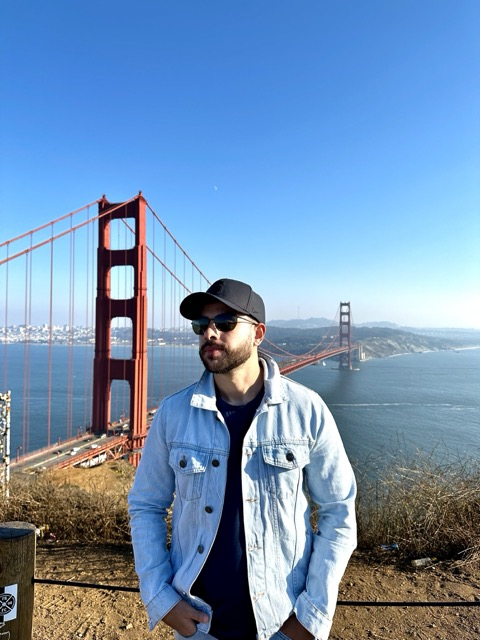

In [ ]:
IPython.display.Image(filename='san_francisco.jpeg')

In [ ]:
query_ollama_with_client(
    "Describe this image",
    MODEL_ID,
    img_path='san_francisco.jpeg',
)

Response from ollama client:
Here's a description of the image:

**Overall Impression:**

The image is a selfie taken by a man against the backdrop of the iconic Golden Gate Bridge in San Francisco. It’s a bright, sunny day, and the bridge dominates the background.

**Subject:**

*   **Man:** A young man with dark hair, a beard, and sunglasses is the primary subject. He's wearing a light blue denim jacket over a black t-shirt. He's looking directly at the camera with a slight smile. He's holding his hands in his pockets.
*   **Pose:** He's standing with a casual, relaxed pose, leaning slightly forward.

**Background:**

*   **Golden Gate Bridge:** The Golden Gate Bridge is the most prominent feature. It's a striking red color and appears large and impressive against the sky.
*   **San Francisco Skyline:** In the distance, you can see parts of the San Francisco skyline, including buildings and ships on the water.
*   **Sky:** The sky is a clear, bright blue.

**Composition:**

*   The m

### Using `requests` lib

In [ ]:
import json
import base64
import requests
from PIL import Image
from io import BytesIO

In [ ]:
def query_model_with_requests(prompt: str, model_id: str, url: str, img_path: list = None) -> None:
    """Queries the model server using the `requests` library.

    Args:
        prompt: The prompt to send to the model.
        model_id: The ID of the model to use.
        url: The URL of the Ollama server.
    """


    data: Dict[str, str] = {
      "model": model_id,
      "prompt": prompt,
    }

    if img_path:
        with Image.open(img_path) as img:
            with BytesIO() as buffer:
                img.save(buffer, format='PNG')
                image_bytes = buffer.getvalue()
                image_bytes_encoded = base64.b64encode(image_bytes)
                data["images"] = [image_bytes_encoded]


    try:
      response = requests.post(f"{url}/api/generate", json=data, stream=True)
      response.raise_for_status()

      for line in response.iter_lines():
        if line:
            try:
                json_line = json.loads(line)
                print(json_line.get("response", ""), end="", flush=True)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line}")
      print()
    except requests.exceptions.RequestException as e:
        print(f"Error querying model with requests: {e}")

#### Text prompt

In [ ]:
query_model_with_requests(
    PROMPT,
    MODEL_ID,
    ngrok_tunnel.public_url,
)

Okay, let's break down why the sky is blue – it's a fantastic example of a physics phenomenon called **Rayleigh scattering**. Here's the explanation:

**1. Sunlight and Colors:**

* Sunlight appears white, but it's actually made up of *all* the colors of the rainbow (red, orange, yellow, green, blue, indigo, violet).  Think of a prism splitting light.

**2. Entering the Atmosphere:**

* When sunlight enters the Earth's atmosphere, it collides with tiny air molecules (mostly nitrogen and oxygen).

**3. Rayleigh Scattering:**

* **This is the key!** Rayleigh scattering describes how light is scattered by particles that are *much smaller* than the wavelength of the light.
* **Shorter wavelengths scatter more:** Blue and violet light have shorter wavelengths than other colors. Because of this, they are scattered *much* more strongly by the air molecules.  It's like throwing a small ball (blue light) at a bumpy surface – it bounces off in all directions.  A larger ball (red light) would be 

#### Multi-modal prompt (text and image)

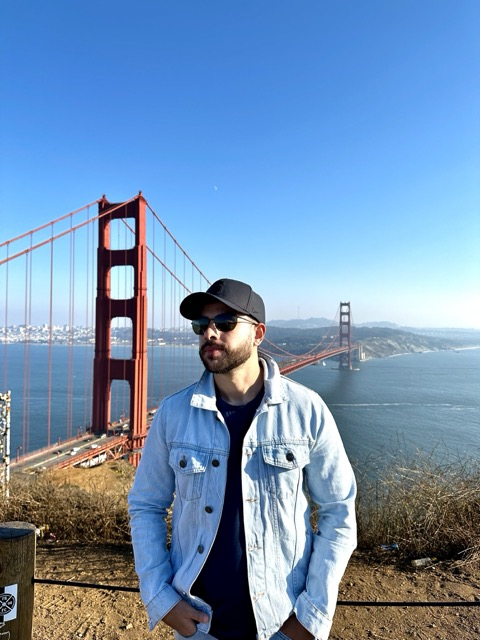

In [ ]:
IPython.display.Image(filename='san_francisco.jpeg')

In [ ]:
query_model_with_requests(
    "Describe this image",
    MODEL_ID,
    ngrok_tunnel.public_url,
    img_path='san_francisco.jpeg',
)

Here's a description of the image:

**Overall Impression:**

The image is a scenic shot of a man posing with the iconic Golden Gate Bridge in the background. It’s a bright, sunny day, and the overall feel is one of travel and adventure.

**Foreground:**

*   **Man:** A young man with dark hair, sunglasses, and a black baseball cap is the primary subject. He's wearing a light blue denim jacket over a black t-shirt. He's leaning slightly against a wooden fence, with one hand holding his jeans.
*   **Fence:** A weathered wooden fence is visible in the lower part of the frame.

**Background:**

*   **Golden Gate Bridge:** The dominant feature is the Golden Gate Bridge, a massive red-orange suspension bridge. It spans across the water, creating a dramatic backdrop.
*   **Water:** The San Francisco Bay is visible, with the water appearing a dark teal color.
*   **Cityscape:** A hazy cityscape is visible in the distance, suggesting San Francisco.

**Lighting and Atmosphere:**

*   The lightin